In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from mutation import *
from crossover import *
from rmp import *
from mfea import *
from task import *
from llm import *
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
load_dotenv()

GPT_API_KEY = os.getenv("GPT_API_KEY")

llm = GPTModel(GPT_API_KEY, "gpt-3.5-turbo-0125", 0.7)

In [22]:
cec2017_tasks = get_2_tasks(0)

In [23]:
num_indis_per_task = 50
indi_len = 50
mutation = PolynomialMutation(5, 0.02)
crossover = SBXCrossover(mutation, eta=2)
# crossover = BLXCrossover()
rmp = AdaptiveRMPMatrix(rmp_pop_size=3, num_gen=3, pc=0.8, pm=0.1)

optimums = np.full(len(cec2017_tasks), 0.0)
amfea = AMFEA(num_indis_per_task, indi_len, cec2017_tasks, crossover, mutation, rmp, optimums)

Initialization:
Task 0:
Best Fitness: 31.545201030192484
Mean Fitness: 42.762440054987835

Task 1:
Best Fitness: 34503.64925909328
Mean Fitness: 41859.76310619173



In [24]:
bfs, mfs = amfea.fit(max_eval=1000000,monitor=True, monitor_rate=100, llm_rate=100)

Gen 0
Evaluation count: 200
Task 0, Best: 25.14411735534668, Avg: 35.755912107950024
Task 1, Best: 20102.892578125, Avg: 33518.95736979366
Time taken each gen: 0.0142 seconds

Creating 3 strategies
Evaluating strategy
Strategy: Utilize task_performance to assign higher mating probabilities to tasks with lower convergence percentages
Creating code...
RMP function: import numpy as np

def get_rmp_matrix(task_count, task_performance, diversity, convergence, task_similarity):
    rmp_matrix = np.zeros((task_count, task_count))
    
    for i in range(task_count):
        for j in range(i, task_count):
            rmp_matrix[i][j] = (1 - task_performance[i]/100) * (1 - task_performance[j]/100)
            rmp_matrix[j][i] = rmp_matrix[i][j]
    
    return rmp_matrix
Invalid RMP matrix generated, attempting to fix
[[1.         0.01483546]
 [0.01483546 1.        ]]
Better off count: 10
Performance: 100.0
Evaluating strategy
Strategy: Leverage diversity values to increase mating probabilities

KeyboardInterrupt: 

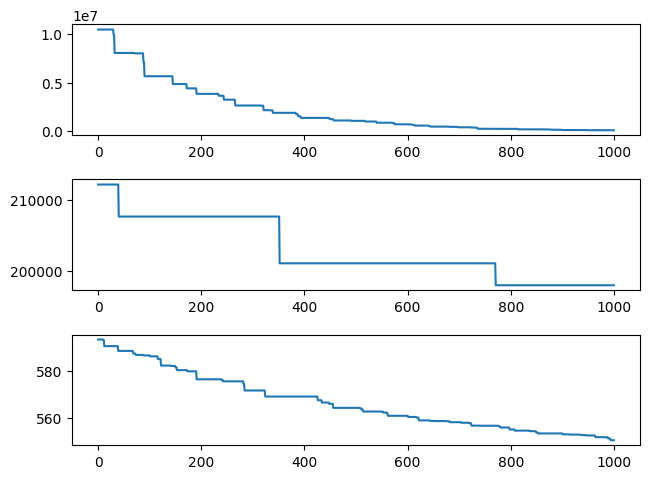

In [ ]:
num_tasks = len(tasks)
fig, axes = plt.subplots(num_tasks, 2)
fig.tight_layout()
for i in range(num_tasks):
    axes[i][0].plot(bfs[i])
    axes[i][1].plot(mfs[i])

In [3]:
ideas = deepseek.initial_ideas(3)

Creating 3 ideas


In [4]:
print(ideas[0])
print(ideas[1])
print(ideas[2])

Use a sigmoid-based RMP that adjusts based on the difference in skill factors, where parents with similar skill factors have higher RMP, but the fitness scores modulate the steepness of the sigmoid to allow more exploration when fitness differences are small.
Incorporate a dynamic thresholding mechanism where RMP is high if both parents belong to the same skill factor, but if they differ, the RMP decays exponentially with the absolute difference in fitness, scaled by the ratio of their skill factors.
Design a hybrid RMP that combines a base probability (from skill factor similarity) with a perturbation term derived from the normalized fitness ratio, ensuring that even dissimilar parents can mate if their fitness scores are highly complementary.


In [5]:
code = deepseek.idea_to_code_function(ideas[0])
print(code)

def get_rmp(p1, p2, p1_skill_factor, p2_skill_factor, p1_fitness, p2_fitness):  
    skill_diff = np.abs(p1_skill_factor - p2_skill_factor)  
    normalized_skill_diff = skill_diff / np.max(skill_diff + 1e-10)  
    fitness_diff = np.abs(p1_fitness - p2_fitness)  
    normalized_fitness_diff = fitness_diff / (np.max(fitness_diff) + 1e-10)  
    steepness = 10.0 * (1.0 - normalized_fitness_diff)  
    rmp = 1.0 / (1.0 + np.exp(steepness * (normalized_skill_diff - 0.5)))  
    return rmp
